In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import prince
import importlib

import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from networkx.algorithms import bipartite

import utils2
from utils2 import *
import graphfunk
from graphfunk import *


/tmp/ipykernel_794596/2578097411.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## French CA fitting

Redoing the entire pipeline for testing the network, only for the french subset. Las step before validation

In [21]:
#Load the edge list
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

edgelist = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)


#Load french followers - to be used in the actual CA fitting process, and for updating the edgelist of markers and followers
full_path2 = '/home/livtollanes/NewData/french/french1.csv'

req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'language', 'country','timestamp_utc']

dtypes = {
    'follower_id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'description_cleantext': 'object',
    'location': 'object',
    'language': 'object',
    'country': 'object',
    'timestamp_utc': 'float64'
}

french_bios = pd.read_csv(full_path2, usecols=req_cols, dtype=dtypes, engine= 'python')



# Load the marker bios and rename ID columns
full_path = '/home/livtollanes/SocialMarkers/markers_bios_2023-05-19.csv'

req_cols = ['twitter_name', 'id', 'tweets', 'followers']

dtypes = {
    'twitter_name': 'object',
    'id': 'object',
    'description': 'object',
    'tweets': 'int64',
    'followers': 'int64'}

marker_ids = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes)


#rename the twittwer id column to follower id 
marker_ids.rename(columns={'id':'marker_id'}, inplace=True)


# Full path to the Excel file where types and names of brands are stored
file_path = '/home/livtollanes/SocialMarkers/MarkersFrenchTwitter.xlsx'

# Load the Excel file
cats = pd.read_excel(file_path)

Create the informative edgelist and match with french users
Add twitter name, type, and followers to the edge list 

In [7]:
utils2.summary_stats(edgelist)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Data types of columns:
 marker_id      object
follower_id    object
dtype: object

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [8]:
utils2.summary_stats(french_bios)

Shape of DataFrame:  (115093, 8)

Columns in DataFrame:  ['follower_id', 'screen_name', 'description', 'timestamp_utc', 'location', 'description_cleantext', 'language', 'country']

Data types of columns:
 follower_id               object
screen_name               object
description               object
timestamp_utc            float64
location                  object
description_cleantext     object
language                  object
country                   object
dtype: object

Number of unique values in 'follower_id':  115093
Number of duplicate values in 'follower_id':  0

Number of missing values in each column:
'follower_id':  0
'screen_name':  0
'description':  0
'timestamp_utc':  0
'location':  0
'description_cleantext':  0
'language':  0
'country':  0

Number of duplicate rows:  0


In [22]:
utils2.compare_column_values(edgelist, french_bios, column= "follower_id")

There are 1077439 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


In [23]:
#map marker_ids onto cats from marker:ids
cat_id = cats.merge(marker_ids, on='twitter_name', how='left')
cat_id = cat_id.drop_duplicates(subset='marker_id')

In [25]:
#streamline the edgelist according to the french bio df. Only keep rows where follower ID exist in the french df
edgelist2 = utils2.streamline_IDs(source= french_bios, df_tofilter=edgelist, column= 'follower_id')

Number of unique follower_id in source DataFrame: 115093
Number of unique follower_id in filtered DataFrame after filtering: 115093
Removed 8427230 rows from the DataFrame to be filtered.
1186892 rows are left in the filtered DataFrame.


In [14]:
#One brand was removed. which one?
pd.set_option('display.max_rows', None)
first_rows1 = edgelist.drop_duplicates(subset='marker_id', keep='first')
first_rows2 = edgelist2.drop_duplicates(subset='marker_id', keep='first')


# Python
first_rows1[~first_rows1['marker_id'].isin(first_rows2['marker_id'])]


# Filter the DataFrame
filtered_df = edgelist[edgelist['marker_id'] == '882270183875915776']

# Print the number of rows
print(len(filtered_df))

cat_id.loc[cat_id['marker_id']== '882270183875915776'] 

#In the original edgelist (not only french users), there were 40 followers for sergio Tacchini. 
#When streamlining the edgelist to only include french people, this brand got removed entirely. These were all people categorised as non french in previpus steps.  

#edgelist.loc[edgelist['marker_id'] == '882270183875915776'] 

marker_id follower_id
1096002  882270183875915776   142130164

In [27]:
#streamline cat_id. Only include ids in cat id that exist in the frencg edge list
cat_id_french = streamline_IDs(source = edgelist2, df_tofilter = cat_id, column= 'marker_id') # One of the brands didnt have any followers for some reason. (Famille et Education - Magazine de l'APEL)

Number of unique marker_id in source DataFrame: 234
Number of unique marker_id in filtered DataFrame after filtering: 234
Removed 3 rows from the DataFrame to be filtered.
234 rows are left in the filtered DataFrame.


In [29]:
# Python
cat_id[~cat_id['marker_id'].isin(cat_id_french['marker_id'])] #check where marker id in cat_id are not in cat_id french

marque     twitter_name      type  \
18                                 Napapijiri     Napapijiri97     sport   
22                            Sergio Tacchini  SergioTacchiniA     sport   
89  Famille et Education - Magazine de l'APEL              NaN  magazine   

   Unnamed: 3           marker_id  tweets  followers  
18        NaN          1059975643     8.0        1.0  
22        NaN  882270183875915776    79.0      310.0  
89        NaN                 NaN     NaN        NaN

In [43]:
category_id_nodupes.head(2)

marque twitter_name   type Unnamed: 3  marker_id   tweets  followers
0    Nike         Nike  sport        NaN  415859364  38240.0  9788339.0
1  Adidas     adidasFR  sport        NaN   25487201  16680.0   393006.0

In [44]:
category_id_nodupes = cat_id_french.drop_duplicates()

#Get the twitter_name column from cat_id into the edge list by merging on marker_id
edgelist_CA = edgelist2.merge(category_id_nodupes[['marker_id', 'twitter_name', 'type', 'followers']], on='marker_id', how='left')

In [51]:
# # #Now write the two dfs to csvs to save them in case something happens
edgelist_CA.to_csv('/home/livtollanes/NewData/french/french_edgelist.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

## Graph Overview - CA Prep

- In this notebook, I will perform various check in order to make sure my data is ready for CA implementation

- This includes:
    - Data distribution checks
    - Node and edge analysis; various graph metrics and visualisations. Are there any clusters etc?
    - Assumptions of CA?
    - Connectedness of my graph

I'm starting with an edge list. Each row represents an edge (a follower-brand relationship) in the graph. From the edge list, I should create a directed graph. 

Make dge list into a graph.
An edge list is a simple, tabular representation of a graph, while a graph is amore complex data structure that allows for more advance operations, such s finding paths and calculating graph metrics.

### Graph metrics

In [3]:
# load data
path = '/home/livtollanes/NewData/french/french_edgelist.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'type': 'object',
          'followers': 'int64'}


edgelist = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [10]:

# Create a new bipartite graph
B = nx.DiGraph() #directed graph

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(edgelist['follower_id'].unique(), bipartite=0) #adding a node for each unique follower. Set 1 in the bipartite graph
B.add_nodes_from(edgelist['twitter_name'].unique(), bipartite=1) #adding a node for each unique marker. Set 2 in the bipartite graph
 
# Add edges
B.add_edges_from(list(zip(edgelist['follower_id'], edgelist['twitter_name'])))  #edges are directed from the first to the second element. So direction is; follower --> Marker

In [11]:
#sanity checks. Numbers of nodes and edges make sense. Graph seems to be connected
print("Number of nodes:", B.number_of_nodes())
print("Number of edges:", B.number_of_edges())

B_undirected = B.to_undirected()
print("Is the graph connected?", nx.is_connected(B_undirected))

Number of nodes: 1192767
Number of edges: 9614122
Is the graph connected? True


In [13]:
nx.is_weakly_connected(B)   #test directed graph for weak connectivity. weakly connected if and only if the graph is connected when the direction of the edge between nodes is ignored
# Being weakly connected signifies that the graph is connected when the direction of the edge between nodes is ignored. There is a path from any node to any other node in the graph when the direction of the edge between nodes is ignored.

True

In [17]:
#project our bipartite graph onto two unipartite graphs
followers, markers = bipartite.sets(B)


# Convert to undirected graph
B_undirected = B.to_undirected()

# Create the projection
G_markers = bipartite.projected_graph(B_undirected, markers) #marker nodes are connected if they share a follower in B. This allows us to analyse what markers tend to be followed by the same people
#G_followers = bipartite.projected_graph(B_undirected, followers) #follower nodes are connected if they share a followed marker in B

In [25]:
G2_markers = bipartite.weighted_projected_graph(B_undirected, markers) 

The weighted projected graph is the projection of the bipartite network B onto the specified nodes with weights representing the number of shared neighbors or the ratio between actual shared neighbors and possible shared neighbors if ratio is True [1]. The nodes retain their attributes and are connected in the resulting graph if they have an edge to a common node in the original graph.

In [18]:
unique_marker_df = edgelist.drop_duplicates(subset='marker_id')[['marker_id', 'twitter_name', 'type']]

In [22]:
# Calculate the degree of each node (degree is the number of edges connected to the node. In the context of the projected marker graph, it represents the number of other brands with which the brand shares followers.)
degree = G_markers.degree()

# Sort the nodes by degree in descending order
sorted_nodes = sorted(degree, key=lambda x: x[1], reverse=True)

# Print the top 10 brands that are followed by the same people as the most other brands
for node, degree in sorted_nodes[:10]:
    print(f"Brand: {node}, Shared followers with {degree} other brands")



Brand: francebleu, Shared followers with 234 other brands
Brand: franceculture, Shared followers with 234 other brands
Brand: le_gorafi, Shared followers with 233 other brands
Brand: OM_Officiel, Shared followers with 233 other brands
Brand: Europe1, Shared followers with 233 other brands
Brand: BFMTV, Shared followers with 233 other brands
Brand: LEXPRESS, Shared followers with 233 other brands
Brand: lesinrocks, Shared followers with 233 other brands
Brand: Sciences_Avenir, Shared followers with 232 other brands
Brand: LaTribune, Shared followers with 232 other brands


In [27]:
# For each brand
for node in G2_markers.nodes:
    # Get the neighbors of the brand and the number of shared followers
    neighbors = [(nbr, d['weight']) for nbr, d in G2_markers[node].items()]
    
    # Sort the neighbors by the number of shared followers in descending order
    sorted_neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)
    
    # Get the top three brands
    top_three_brands = sorted_neighbors[:3]
    
    # Print the brand and the top three brands it shares the most followers with
    print(f"Brand: {node}")
    for brand, shared_followers in top_three_brands:
        print(f"Shares {shared_followers} followers with brand: {brand}")
    print("\n")

Brand: UnilimDSI
Shares 27 followers with brand: Mediapart
Shares 24 followers with brand: BFMTV
Shares 24 followers with brand: franceculture


Brand: sofoot
Shares 41969 followers with brand: PSG_inside
Shares 36058 followers with brand: Mediapart
Shares 33663 followers with brand: OM_Officiel


Brand: CarrefourFrance
Shares 31623 followers with brand: Cdiscount
Shares 30421 followers with brand: Fnac
Shares 20078 followers with brand: boulanger


Brand: Reporterre
Shares 40534 followers with brand: Mediapart
Shares 27641 followers with brand: franceculture
Shares 24007 followers with brand: le_gorafi


Brand: AngersSCO
Shares 25903 followers with brand: PSG_inside
Shares 24840 followers with brand: OL
Shares 24312 followers with brand: OM_Officiel


Brand: QuickFrance_
Shares 1187 followers with brand: Cdiscount
Shares 1140 followers with brand: PSG_inside
Shares 1129 followers with brand: BurgerKingFR


Brand: LPHurleventBLF
Shares 32 followers with brand: franceculture
Shares 20 f

- The spring layout used below tends to group groups of well connected nodes close to each other
- Euclidian distance: measure of the straight line distance between two points in space

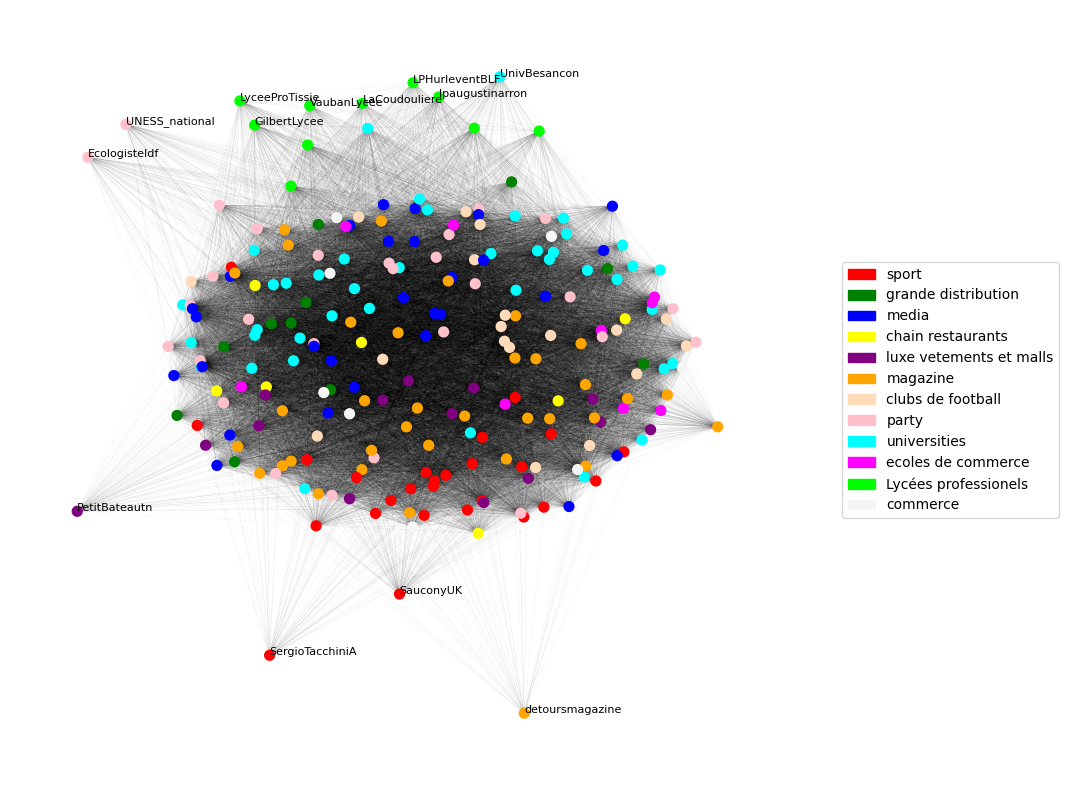

In [41]:
# Manually specify a list of 12 classic colors
classic_colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'peachpuff', 'pink', 'cyan', 'magenta', 'lime', 'whitesmoke']

# Get the unique types and assign a color to each one
unique_types = unique_marker_df['type'].unique()
type_color = {utype: classic_colors[i % len(classic_colors)] for i, utype in enumerate(unique_types)}


# Create a dictionary that maps each twitter_name to its type
twitter_name_to_type = dict(zip(unique_marker_df['twitter_name'], unique_marker_df['type']))

# Create a list of colors for each node in the graph
node_colors = [type_color[twitter_name_to_type[node]] for node in G_markers.nodes()]

# Draw the graph with node colors
plt.figure(figsize=(10, 10))  # Increase figure size
pos = nx.spring_layout(G_markers)  # Use spring layout

# Draw edges with increased alpha
nx.draw_networkx_edges(G_markers, pos, alpha=0.2, width=0.1)

# Draw nodes with original alpha and node colors
nx.draw_networkx_nodes(G_markers, pos, node_color=node_colors, node_size=50, alpha=1.0)

# Calculate the center of the graph by averaging the positions of all nodes
center = np.array([0.0, 0.0])  # Initialize as float array
for coord in pos.values():
    center += np.array(coord)
center /= len(pos)

# Define the distance for nodes to be considered "outside the main cluster"
distance = 0.65

# Draw labels for nodes outside the main cluster
for node, coord in pos.items():
    if np.linalg.norm(np.array(coord) - center) > distance:
        plt.text(coord[0], coord[1], node, fontsize=8)

# Create legend
patches = [mpatches.Patch(color=color, label=utype) for utype, color in type_color.items()]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(0.95, 0.5), bbox_transform=plt.gcf().transFigure)

# Remove axes
plt.axis('off')

plt.show()

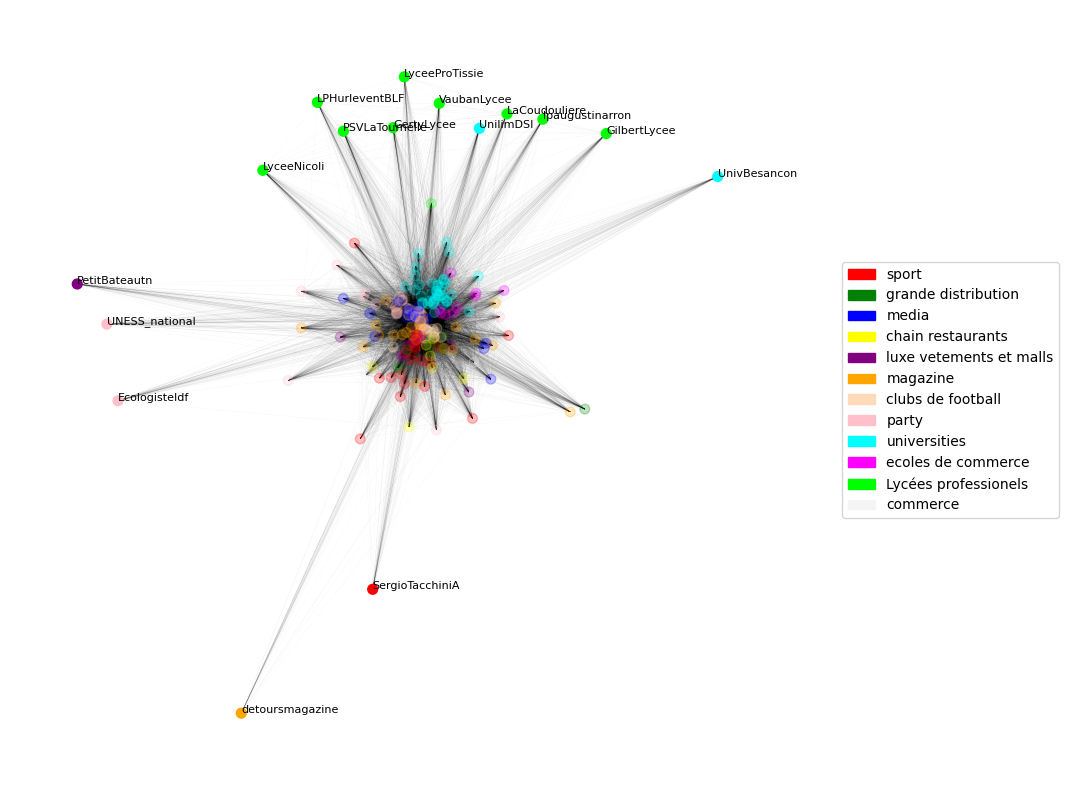

In [83]:
# Define the weight threshold
weight_threshold = 0  # Adjust this value based on your data

# Create a new graph that only includes edges with a weight above the threshold
G_filtered = nx.Graph((u, v, d) for u, v, d in G2_markers.edges(data=True) if d['weight'] > weight_threshold)

# Create a list of colors for each node in the filtered graph
node_colors = [type_color[twitter_name_to_type[node]] for node in G_filtered.nodes()]

# Draw the graph with node colors
plt.figure(figsize=(10, 10))  # Increase figure size
pos = nx.spring_layout(G_filtered, k = 0.15)  # Use spring layout

# Draw edges with increased alpha
nx.draw_networkx_edges(G_filtered, pos, alpha=0.1, width=0.1)

# Calculate the center of the graph
center = np.array([0.0, 0.0])  # Initialize as float array
for coord in pos.values():
    center += np.array(coord)
center /= len(pos)

# Define the distance for nodes to be considered "outside the main cluster"
distance = 0.45

# Create a list of alpha values for each node in the filtered graph
node_alphas = [0.25 if np.linalg.norm(np.array(coord) - center) <= distance else 1.0 for node, coord in pos.items()]

# Draw nodes with original alpha and node colors
nx.draw_networkx_nodes(G_filtered, pos, node_color=node_colors, node_size=50, alpha=node_alphas)

# Draw labels for nodes outside the main cluster
for node, coord in pos.items():
    if np.linalg.norm(np.array(coord) - center) > distance:
        plt.text(coord[0], coord[1], node, fontsize=8)

# Create legend
patches = [mpatches.Patch(color=color, label=utype) for utype, color in type_color.items()]
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(0.95, 0.5), bbox_transform=plt.gcf().transFigure)

# Remove axes
plt.axis('off')

plt.show()

In [101]:
import community as community_louvain
import networkx as nx


# Compute the best partition using the Louvain method
partition = community_louvain.best_partition(G_markers)

# Get the number of unique communities
num_communities = len(set(partition.values()))

print(f"Number of communities: {num_communities}")

Number of communities: 3


In [98]:
# Create a dictionary where the keys are the twitter names and the values are the types
brand_types = pd.Series(unique_marker_df['type'].values,index=unique_marker_df['twitter_name']).to_dict()

# Create a reverse dictionary where the keys are the community labels and the values are lists of brands
communities = {}
for brand, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append((brand, brand_types.get(brand, 'Unknown')))

# Print the brands and their types in each community
for community, brands in communities.items():
    print(f"Community {community}:")
    for brand, brand_type in brands:
        print(f"  {brand} (Type: {brand_type})")
    print()

Community 0:
  UnilimDSI (Type: universities)
  Reporterre (Type: media)
  francebleu (Type: media)
  Actu17 (Type: media)
  Paris_Dauphine (Type: universities)
  univrouen (Type: universities)
  lanouvellerep_ (Type: media)
  LeMediaTV (Type: media)
  Telestarmag (Type: magazine)
  univbourgogne (Type: universities)
  TerreSauvageMag (Type: magazine)
  UGrenobleAlpes (Type: universities)
  NPA_officiel (Type: party)
  Nouvelle_Donne (Type: party)
  lesRepublicains (Type: party)
  essec (Type: ecoles de commerce)
  Mines_Paris (Type: universities)
  ParisMatch (Type: magazine)
  Sciences_Avenir (Type: magazine)
  AssasUniversite (Type: universities)
  UnivPoitiers (Type: universities)
  UCAuvergne (Type: universities)
  AgroParisTech (Type: universities)
  EMLYON (Type: ecoles de commerce)
  telecomparis (Type: universities)
  fipradio (Type: media)
  ENS_ULM (Type: universities)
  RevPermanente (Type: party)
  Ecoledeschartes (Type: universities)
  Telerama (Type: magazine)
  le_goraf

In [96]:
from collections import defaultdict

# Create a nested dictionary where the keys are the community labels and the values are dictionaries with types and counts
communities = defaultdict(lambda: defaultdict(int))
for brand, community in partition.items():
    brand_type = brand_types.get(brand, 'Unknown')
    communities[community][brand_type] += 1

# Print the count of each type in each community, sorted by count in descending order
for community, types in communities.items():
    print(f"Community {community}:")
    for brand_type, count in sorted(types.items(), key=lambda item: item[1], reverse=True):
        print(f"  {brand_type}: {count}")
    print()

Community 0:
  universities: 41
  party: 28
  media: 27
  magazine: 23
  Lycées professionels: 10
  ecoles de commerce: 9
  chain restaurants: 1

Community 2:
  clubs de football: 18
  grande distribution: 10
  magazine: 8
  commerce: 7
  sport: 7
  chain restaurants: 6
  luxe vetements et malls: 5

Community 1:
  sport: 19
  luxe vetements et malls: 9
  magazine: 4
  media: 1
  commerce: 1
  grande distribution: 1



community 0: uni, media, magazine, party, ecoles de commerce, lycee professionels, and a single brand of type chain restaurants
community 1: magazine, grande distribution, cluvbs de football, luxe vetements et malls, commerse, spor, chain restaurants, 
community 2: media, sport, luxe vetements et malls, commerse, 

In [86]:
# Create a reverse dictionary where the keys are the community labels and the values are lists of brands
communities = {}
for brand, community in partition.items():
    if community not in communities:
        communities[community] = []
    communities[community].append(brand)

# Print the brands in each community
for community, brands in communities.items():
    print(f"Community {community}:")
    for brand in brands:
        print(f"  {brand}")
    print()

Community 0:
  UnilimDSI
  Reporterre
  francebleu
  Actu17
  Paris_Dauphine
  univrouen
  lanouvellerep_
  LeMediaTV
  Telestarmag
  univbourgogne
  TerreSauvageMag
  UGrenobleAlpes
  NPA_officiel
  Nouvelle_Donne
  lesRepublicains
  essec
  Mines_Paris
  ParisMatch
  Sciences_Avenir
  AssasUniversite
  UnivPoitiers
  UCAuvergne
  AgroParisTech
  EMLYON
  telecomparis
  fipradio
  ENS_ULM
  RevPermanente
  Ecoledeschartes
  Telerama
  le_gorafi
  unistra
  UGustaveEiffel
  VICEfr
  PartiRadicalG
  inseec_ge
  HECParis
  sciencespo
  Tele2Semaines
  InvestirFr
  AlterEco_
  Europe1
  EDHEC_BSchool
  PartiAnimaliste
  univ_spn
  femmeactuelle
  UnivTours
  universitereims
  lopinion_fr
  mdiplo
  Univ_Orleans
  LaTribune
  UnivParis8
  Univ_Toulouse
  PCF
  SKEMA_BS
  BFMTV
  LEXPRESS
  univ_lyon2
  EELV
  NantesUniv
  ESCP_bs
  FranceInsoumise
  UnivAngers
  Sorbonne_Univ_
  Tele7
  france_soir
  forbes_fr
  partisocialiste
  LutteOuvriere
  Mediapart
  courrierinter
  TeleLoisirs
  un

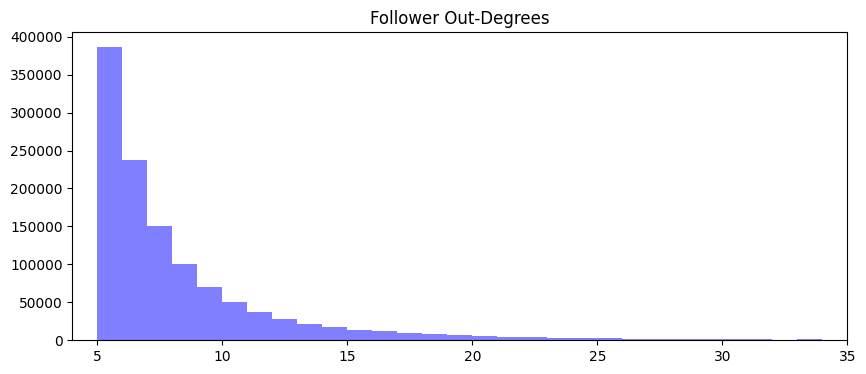

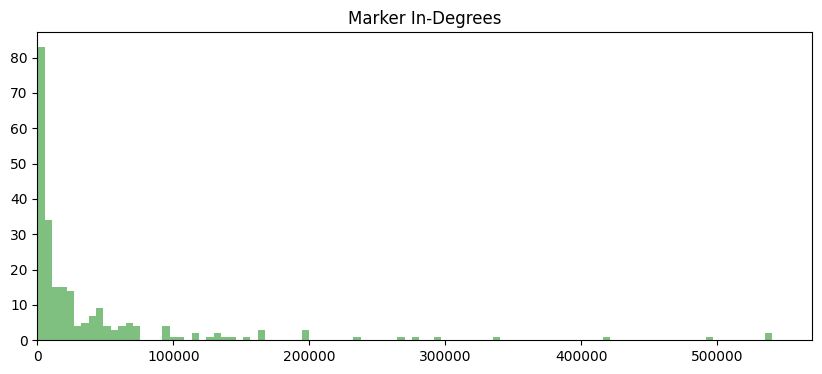

In [19]:
# Analyse and visualise degree distribution (number of edges connected to each node)

# Separate the nodes by type
follower_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
marker_nodes = set(B) - follower_nodes

# Calculate the out-degree of each follower node and in-degree of each marker node
follower_out_degrees = [B.out_degree(n) for n in follower_nodes]
marker_in_degrees = [B.in_degree(n) for n in marker_nodes]

# Plot the out-degree distribution of follower nodes
bins = range(4, 35)

plt.figure(figsize=(10, 4))
plt.hist(follower_out_degrees, bins = bins, alpha=0.5, color='blue')
plt.title('Follower Out-Degrees')
plt.xlim(4, 35)
plt.show()

# Plot the in-degree distribution of marker nodes
plt.figure(figsize=(10, 4))
plt.hist(marker_in_degrees, bins = 100, alpha=0.5, color='green')
plt.title('Marker In-Degrees')
plt.xlim(0, 570000)
plt.show()

- As we can see based on the marker in-degrees plot, a select few brans have a lot of connections compared to teh rest of the markers
- From the follower Out-degree plot, it is evident that most users don't follow more than 10 brands. Following more than 15 brands is even less normal. 

In [20]:
# Calculate weakly connected components
connected_components = list(nx.weakly_connected_components(B))

# Print the number of connected components
print("Number of connected components:", len(connected_components))

# Print the size of the largest connected component
print("Size of largest connected component:", max(len(c) for c in connected_components))

Number of connected components: 1
Size of largest connected component: 1192767


A weakly connected component is a subgraph of the original graph where all vertices are connected to each other by some path, ignoring the direction of edges. Given our number of connected components is 1, we can conclude that our graph is fully connected. 

Community detection

In [21]:
# Calculate in-degree centrality for all nodes in the graph
in_degree_centrality = nx.in_degree_centrality(B)

# Top 5 nodes by in-degree centrality
top_in_degree_nodes = sorted(in_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by in-degree centrality:", top_in_degree_nodes)



Top nodes by in-degree centrality: [('Dior', 0.45296311263064176), ('LouisVuitton', 0.45275938448949754), ('CHANEL', 0.41497242543801555), ('YSL', 0.34924369071553013), ('Nike', 0.28177781727514034)]


In [74]:
# Number of brands
num_brands = len(edgelist['twitter_name'].unique())

# Calculate out-degree for each follower and divide by the number of brands
out_degree_centrality = {follower: out_degree / num_brands for follower, out_degree in B.out_degree() if B.nodes[follower]['bipartite'] == 0}

# Top 5 nodes by out-degree centrality
top_out_degree_nodes = sorted(out_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]

print("Top nodes by out-degree centrality:", top_out_degree_nodes)

Top nodes by out-degree centrality: [('35704105', 0.6340425531914894), ('107042704', 0.4595744680851064), ('1430557124132839431', 0.4425531914893617), ('525429842', 0.4127659574468085), ('819576166055104516', 0.40425531914893614)]


In [ ]:
#Some users follow a lot of brands. Maybe a bit unlikely?
top_followers = edgelist.groupby('follower_id').size().sort_values(ascending=False).head(5)
print(top_followers)

In [75]:
summary_stats(edgelist, print_dtypes=True)

Shape of DataFrame:  (9730265, 3)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name']

Data types of columns:
 marker_id       object
follower_id     object
twitter_name    object
dtype: object

Number of unique values in 'follower_id':  1192532

Number of duplicate values in 'follower_id':  8537733

Number of unique values in 'marker_id':  235

Number of duplicate values in 'marker_id':  9730030

Number of missing values in each column:
 marker_id       0
follower_id     0
twitter_name    0
dtype: int64


In [24]:
#Save edgelist to csv 
edgelist.to_csv('/home/livtollanes/NewData/edgelist.csv', index=False, encoding='utf-8')

## The CA

- Create contingency table (rows are users, columns are brands)
- each cell represents the frequency of interaction between user and brand


In [2]:
# load data
path = '/home/livtollanes/NewData/edgelist.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'type': 'object',
          'followers': 'int64'}


edgelist_CA = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

In [3]:
#creating the contingency table
contingency_table = pd.crosstab(edgelist_CA['follower_id'], edgelist_CA['twitter_name'])

In [4]:
# Initialize a CA object
ca = prince.CA(
    n_components=3,  # Number of components to keep
    n_iter=10,  # Number of iterations for the power method
    copy=True,  # Whether to overwrite the data matrix
    check_input=True,  # Whether to check the input for NaNs and Infs
    engine='sklearn',  # Whether to perform computations in C or Python
    random_state=42  # Random seed for reproducibility
)

# Fit the CA model on the contingency table
ca = ca.fit(contingency_table)

# Get the coordinates of the rows (followers) and columns (brands) on the first two components
row_coordinates = ca.row_coordinates(contingency_table)
column_coordinates = ca.column_coordinates(contingency_table)

print("Row Coordinates:\n", row_coordinates)
print("Column Coordinates:\n", column_coordinates)

Row Coordinates:
                             0         1         2
follower_id                                      
1000000204685312001  0.629827 -2.043692 -1.141925
1000000325695262720  0.937719  0.388769  0.403210
1000000540829417472  0.016897 -1.113688  0.714949
1000004748681072640 -0.935134  0.281821  0.008673
1000005920372518912  0.764223 -0.752355  1.888794
...                       ...       ...       ...
999992864313692160   0.854611  0.011727  0.847312
999994160           -1.160955  0.166750  0.041802
999997228726013953   1.029317  0.718458 -0.050928
999998065712025600   0.474237 -1.801325 -1.089761
999998477307404288   0.551979 -2.131551 -1.179584

[1192532 rows x 3 columns]
Column Coordinates:
                         0         1         2
twitter_name                                 
24heuresactu     0.911811  0.671406  0.022413
ACAjaccio        0.574993 -2.061257 -1.377884
AJA              0.631213 -2.046493 -1.137964
ASICSFrance      0.433976 -0.678342  0.672704
AS_Mona

In [105]:
ca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.808         3.41%                      3.41%
1              0.594         2.51%                      5.92%
2              0.449         1.90%                      7.82%

In [5]:
# Create a DataFrame with unique 'marker_id' and corresponding 'type'
unique_marker_df = edgelist_CA.drop_duplicates(subset='marker_id')[['marker_id', 'twitter_name', 'type']]

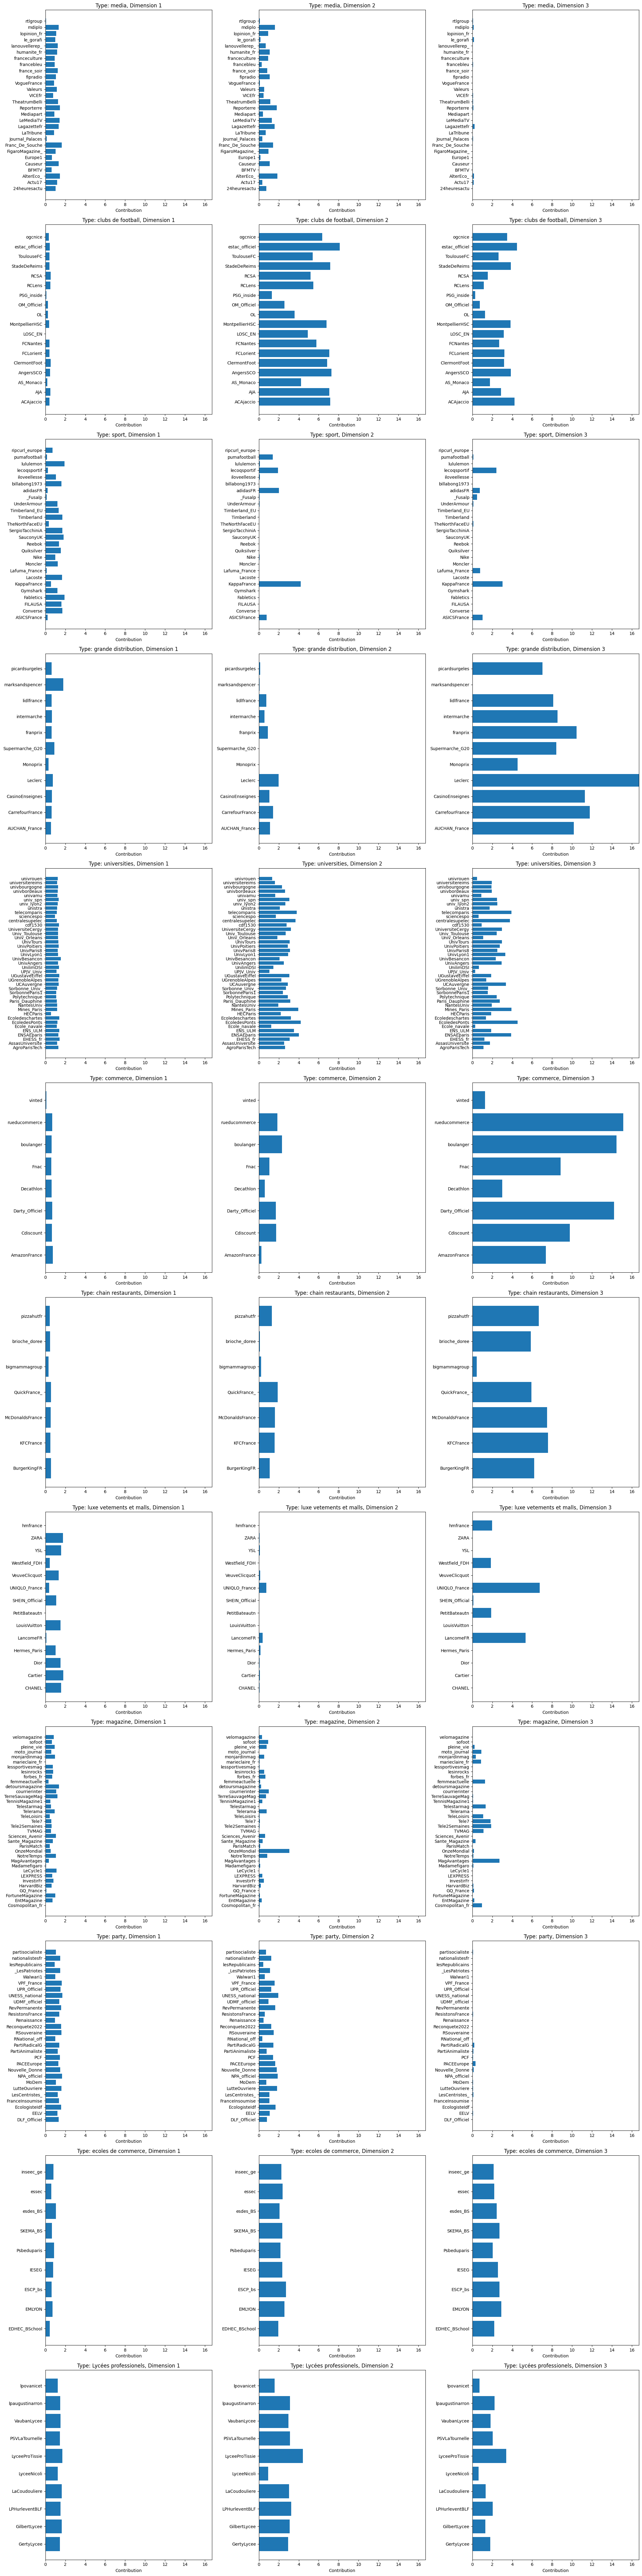

In [107]:
coordinates = column_coordinates
eigenvalues = ca.eigenvalues_

# Calculate the contributions
contributions = coordinates**2 / eigenvalues

# Add the 'type' column to the contributions DataFrame
contributions['type'] = unique_marker_df.set_index('twitter_name')['type']

# Get the unique types
types = contributions['type'].unique()

# Find the maximum contribution across all types and dimensions
max_contribution = contributions[[0, 1, 2]].max().max()

# Create a subplot for each type
fig, axs = plt.subplots(len(types), 3, figsize=(21, 7 * len(types)))

for i, type in enumerate(types):
    # Filter the contributions for the current type
    contributions_type = contributions[contributions['type'] == type]

    for j, ax in enumerate(axs[i]):
        ax.barh(contributions_type.index, contributions_type[j])
        ax.set_xlabel('Contribution')
        ax.set_title(f'Type: {type}, Dimension {j+1}')
        ax.set_xlim(0, max_contribution)  # Set the x-axis limit

plt.tight_layout()
plt.show()

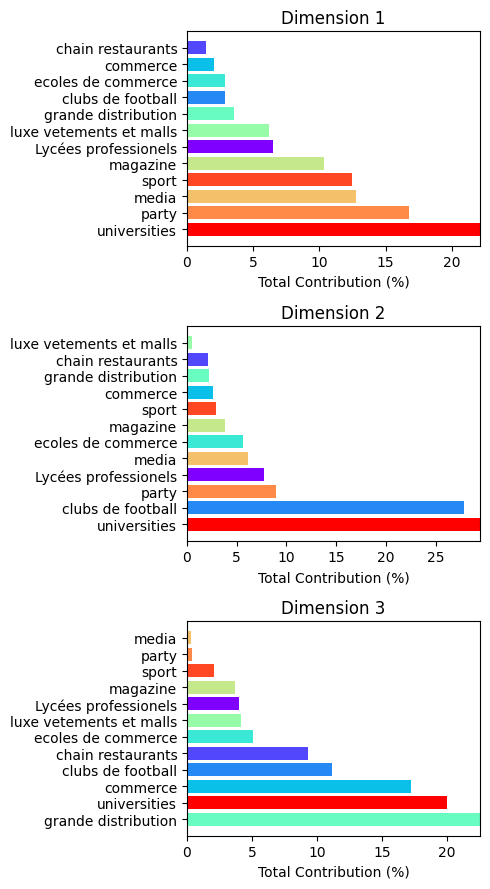

In [108]:


# Calculate the total contribution of each type to each dimension
total_contributions = contributions.groupby('type')[[0, 1, 2]].sum()

# Normalize the contributions so they add up to 100 for each dimension
total_contributions = total_contributions.divide(total_contributions.sum(), axis=1) * 100

# Create a color map
color_map = cm.rainbow(np.linspace(0, 1, len(total_contributions.index)))

# Create a dictionary mapping each type to a color
type_to_color = dict(zip(total_contributions.index, color_map))

# Create a subplot for each dimension
fig, axs = plt.subplots(3, 1, figsize=(5, 9))

for i, ax in enumerate(axs):
    # Sort the total contributions for the current dimension
    total_contributions_sorted = total_contributions.sort_values(by=i, ascending=False)
    
    # Get the colors for the sorted types
    colors = total_contributions_sorted.index.map(type_to_color.get)
    
    ax.barh(total_contributions_sorted.index, total_contributions_sorted[i], color=colors)
    ax.set_xlabel('Total Contribution (%)')
    ax.set_title(f'Dimension {i+1}')
    ax.set_xlim(0, total_contributions_sorted[i].max())  # Set the x-axis limit

plt.tight_layout()
plt.show()

/home/livtollanes/10.jan-thesis/Code/graphfunk.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates_type_sorted[0][i], y_values[i], twitter_name))


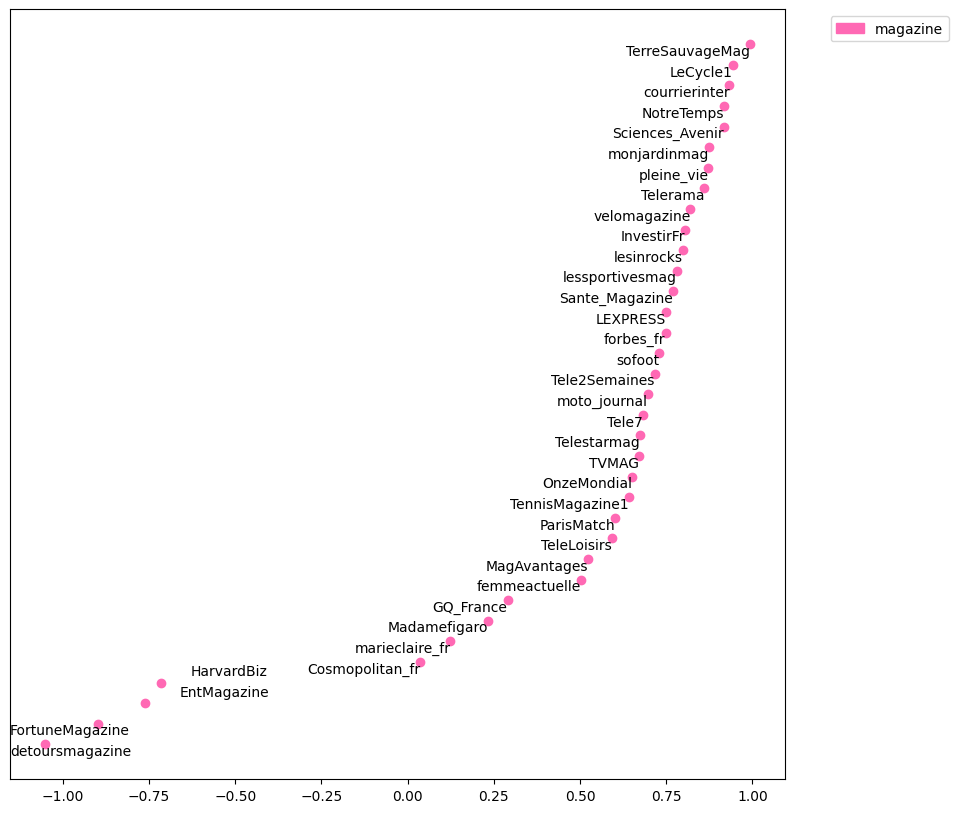

In [99]:
# Call the function with 'sport' type
importlib.reload(graphfunk)

#graphfunk.plot_type(unique_marker_df, column_coordinates, 'sport', 'skyblue')
#graphfunk.plot_type(unique_marker_df, column_coordinates, 'luxe vetements et malls', 'turquoise')
graphfunk.plot_type(unique_marker_df, column_coordinates, 'magazine', 'hotpink')

#graphfunk.plot_type(unique_marker_df, column_coordinates, 'grande distribution', 'green')


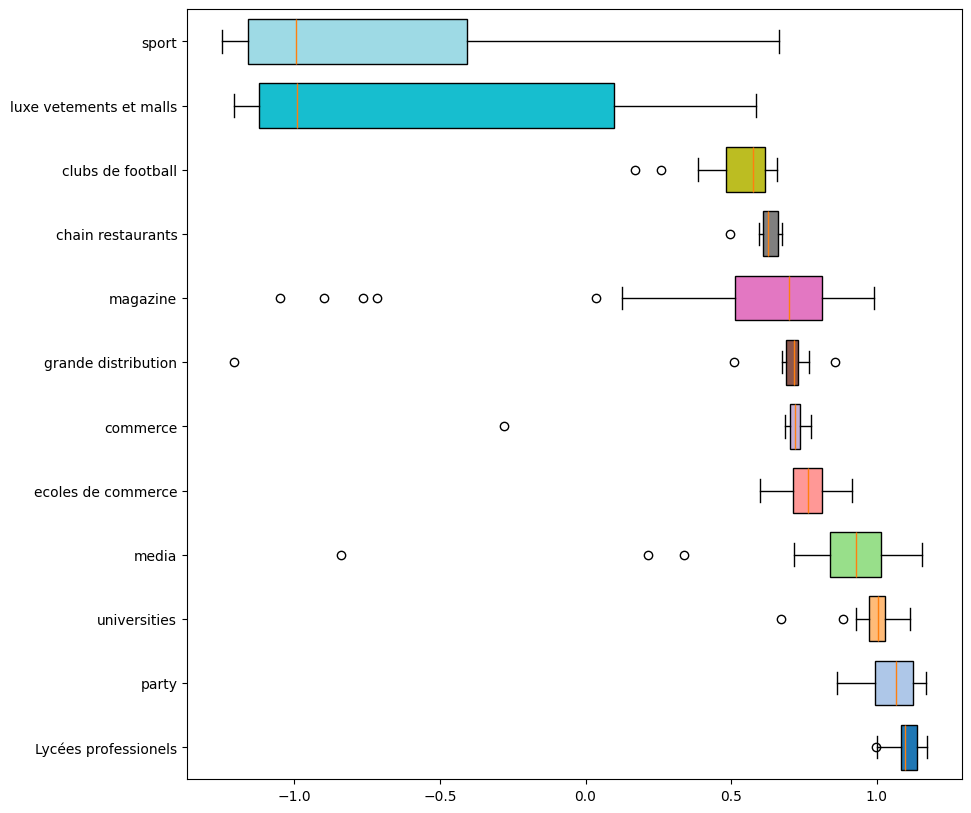

In [32]:
# Create a DataFrame that maps twitter_name to type
twitter_name_to_type = unique_marker_df.set_index('twitter_name')['type']

# Add a 'type' column to column_coordinates
column_coordinates['type'] = twitter_name_to_type

# Calculate the median x-axis value for each type and sort in descending order
type_order = column_coordinates.groupby('type')[0].median().sort_values(ascending=False).index

# Create a color map
cmap = plt.get_cmap('tab20', len(type_order))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Create a box plot for each type
for i, type_ in enumerate(type_order):
    data = column_coordinates[column_coordinates['type'] == type_][0]
    ax.boxplot(data, positions=[i], patch_artist=True, boxprops=dict(facecolor=cmap(i)), vert=False, widths=0.7)

# Set the y-axis labels and limit
ax.set_yticks(range(len(type_order)))
ax.set_yticklabels(type_order)

plt.show()

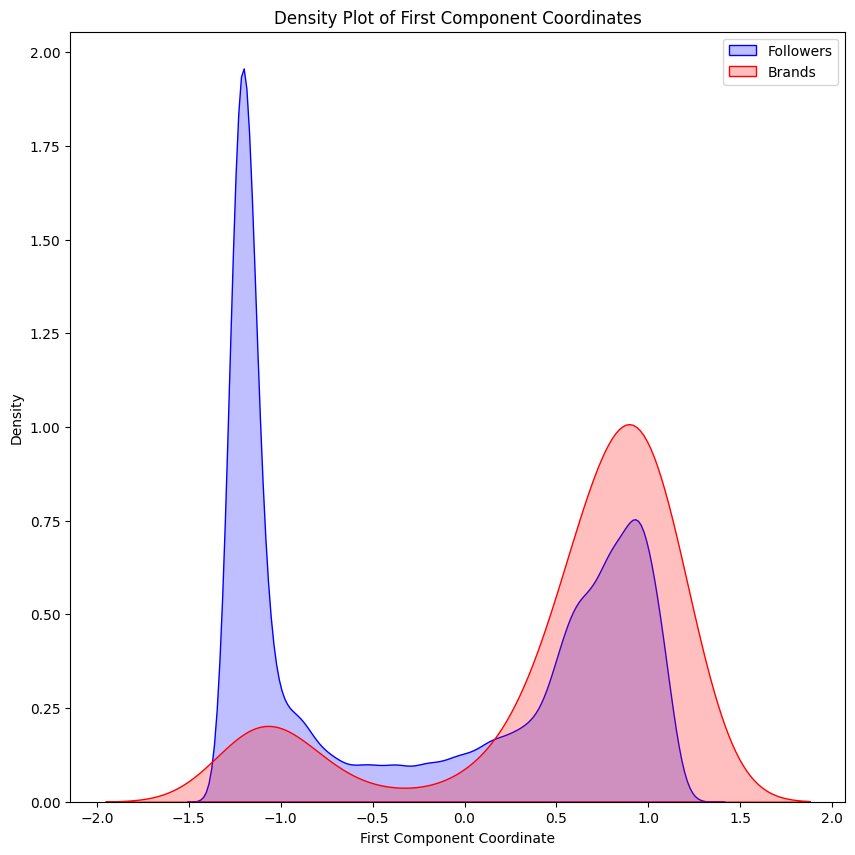

In [34]:
# Get the coordinates for the first component for followers and brands
first_component_followers = row_coordinates.iloc[:, 0]
first_component_brands = column_coordinates.iloc[:, 0]

plt.figure(figsize=(10, 10))

# Create a density plot for followers
sns.kdeplot(first_component_followers, fill=True, color='b', label='Followers')

# Create a density plot for brands
sns.kdeplot(first_component_brands, fill=True, color='r', label='Brands')

plt.xlabel('First Component Coordinate')
plt.title('Density Plot of First Component Coordinates')
plt.legend()

plt.show()

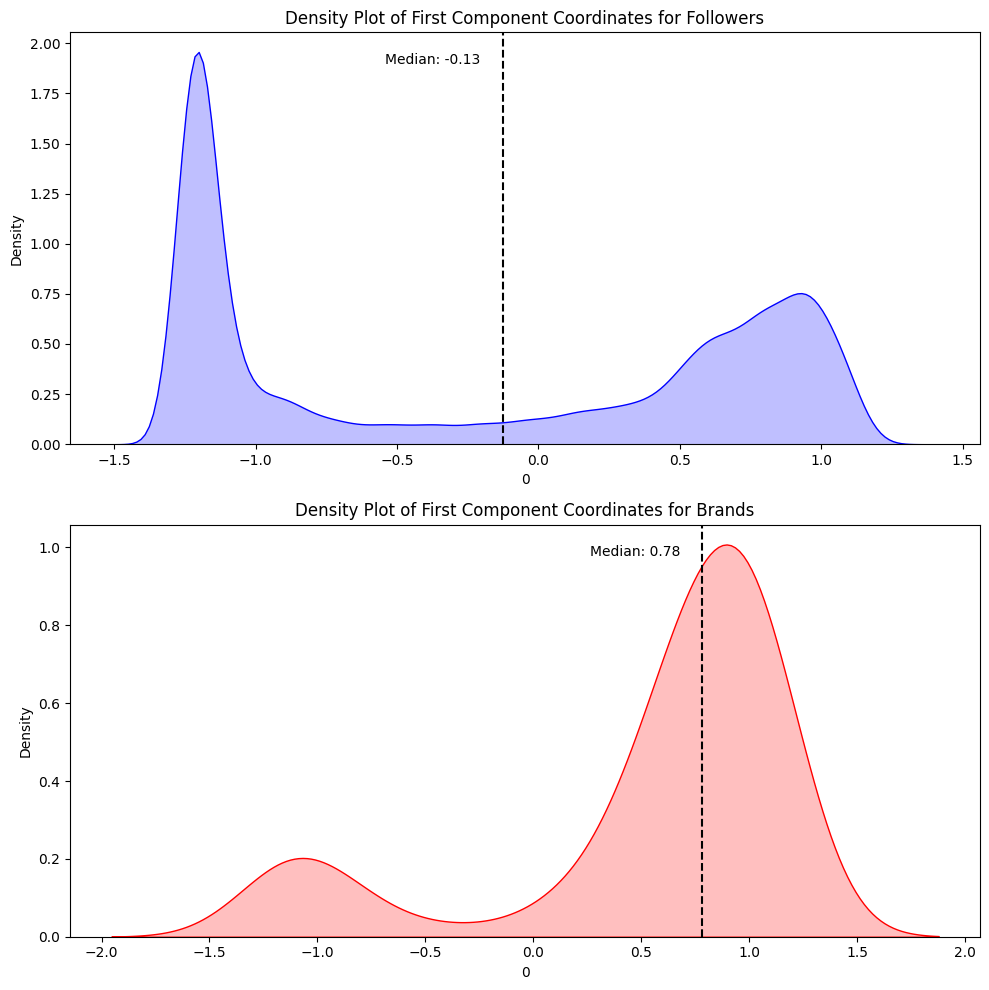

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the coordinates for the first component for followers and brands
first_component_followers = row_coordinates.iloc[:, 0]
first_component_brands = column_coordinates.iloc[:, 0]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Create a density plot for followers
sns.kdeplot(first_component_followers, fill=True, color='b', ax=axs[0])
axs[0].axvline(first_component_followers.median(), color='k', linestyle='--')
axs[0].text(first_component_followers.median()-0.08, axs[0].get_ylim()[1]*0.95, f'Median: {first_component_followers.median():.2f}', ha='right', va='top')
axs[0].set_title('Density Plot of First Component Coordinates for Followers')

# Create a density plot for brands
sns.kdeplot(first_component_brands, fill=True, color='r', ax=axs[1])
axs[1].axvline(first_component_brands.median(), color='k', linestyle='--')
axs[1].text(first_component_brands.median()-0.1, axs[1].get_ylim()[1]*0.95, f'Median: {first_component_brands.median():.2f}', ha='right', va='top')
axs[1].set_title('Density Plot of First Component Coordinates for Brands')

plt.tight_layout()
plt.show()

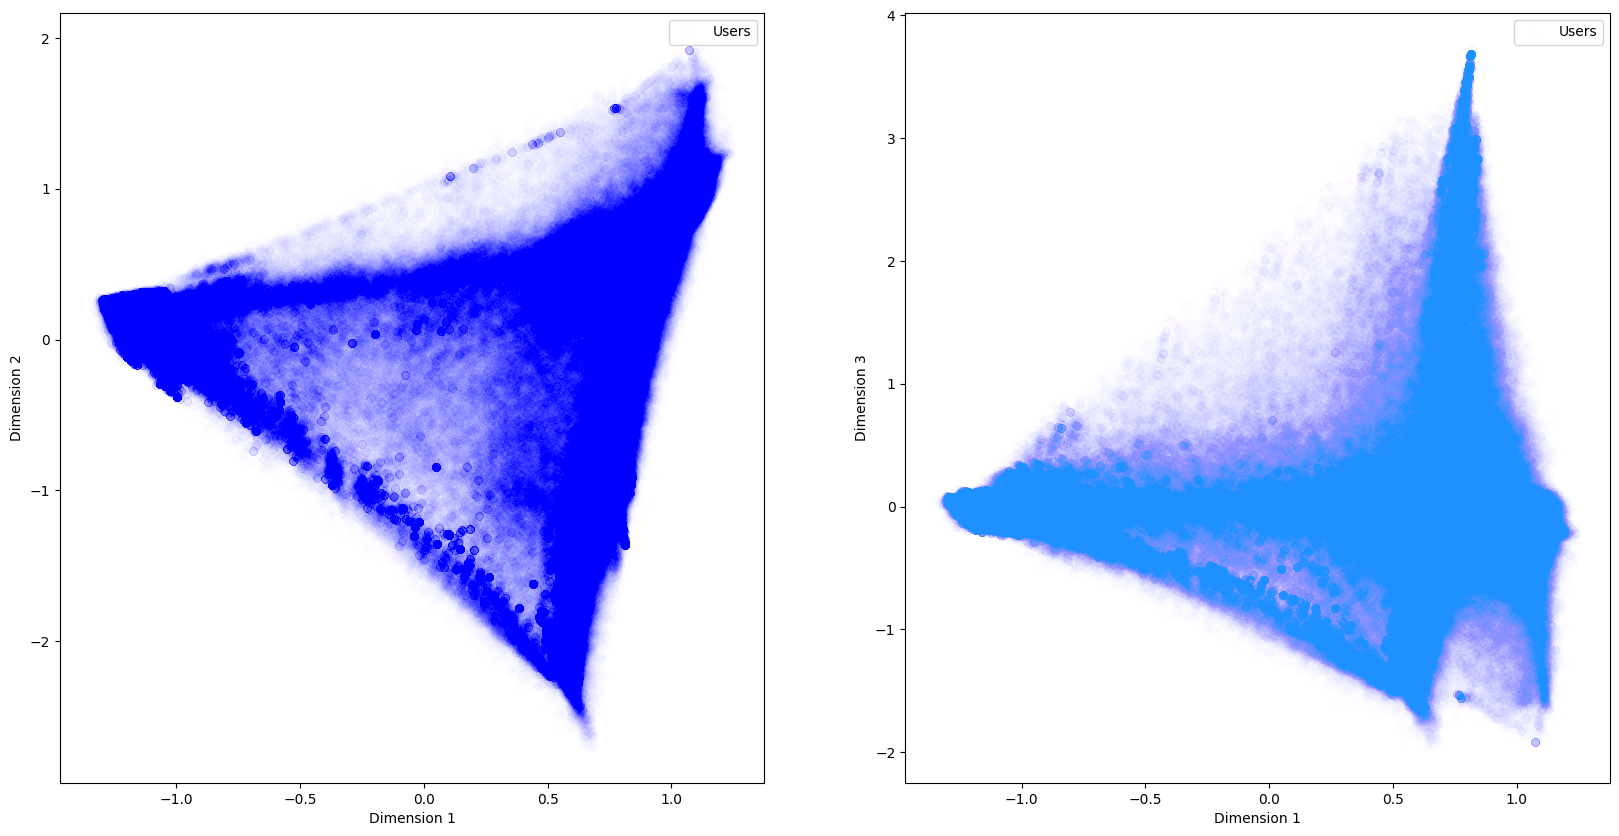

In [50]:
#dimensions agains each other for followers
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(row_coordinates[0], row_coordinates[1], color='blue', label='Users', alpha = 0.003)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(row_coordinates[0], row_coordinates[2], color='dodgerblue', label='Users', alpha = 0.003)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')
plt.legend()

plt.show()

In [115]:
unique_marker_df.columns

Index(['marker_id', 'twitter_name', 'type'], dtype='object')

/tmp/ipykernel_618801/3842471080.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))


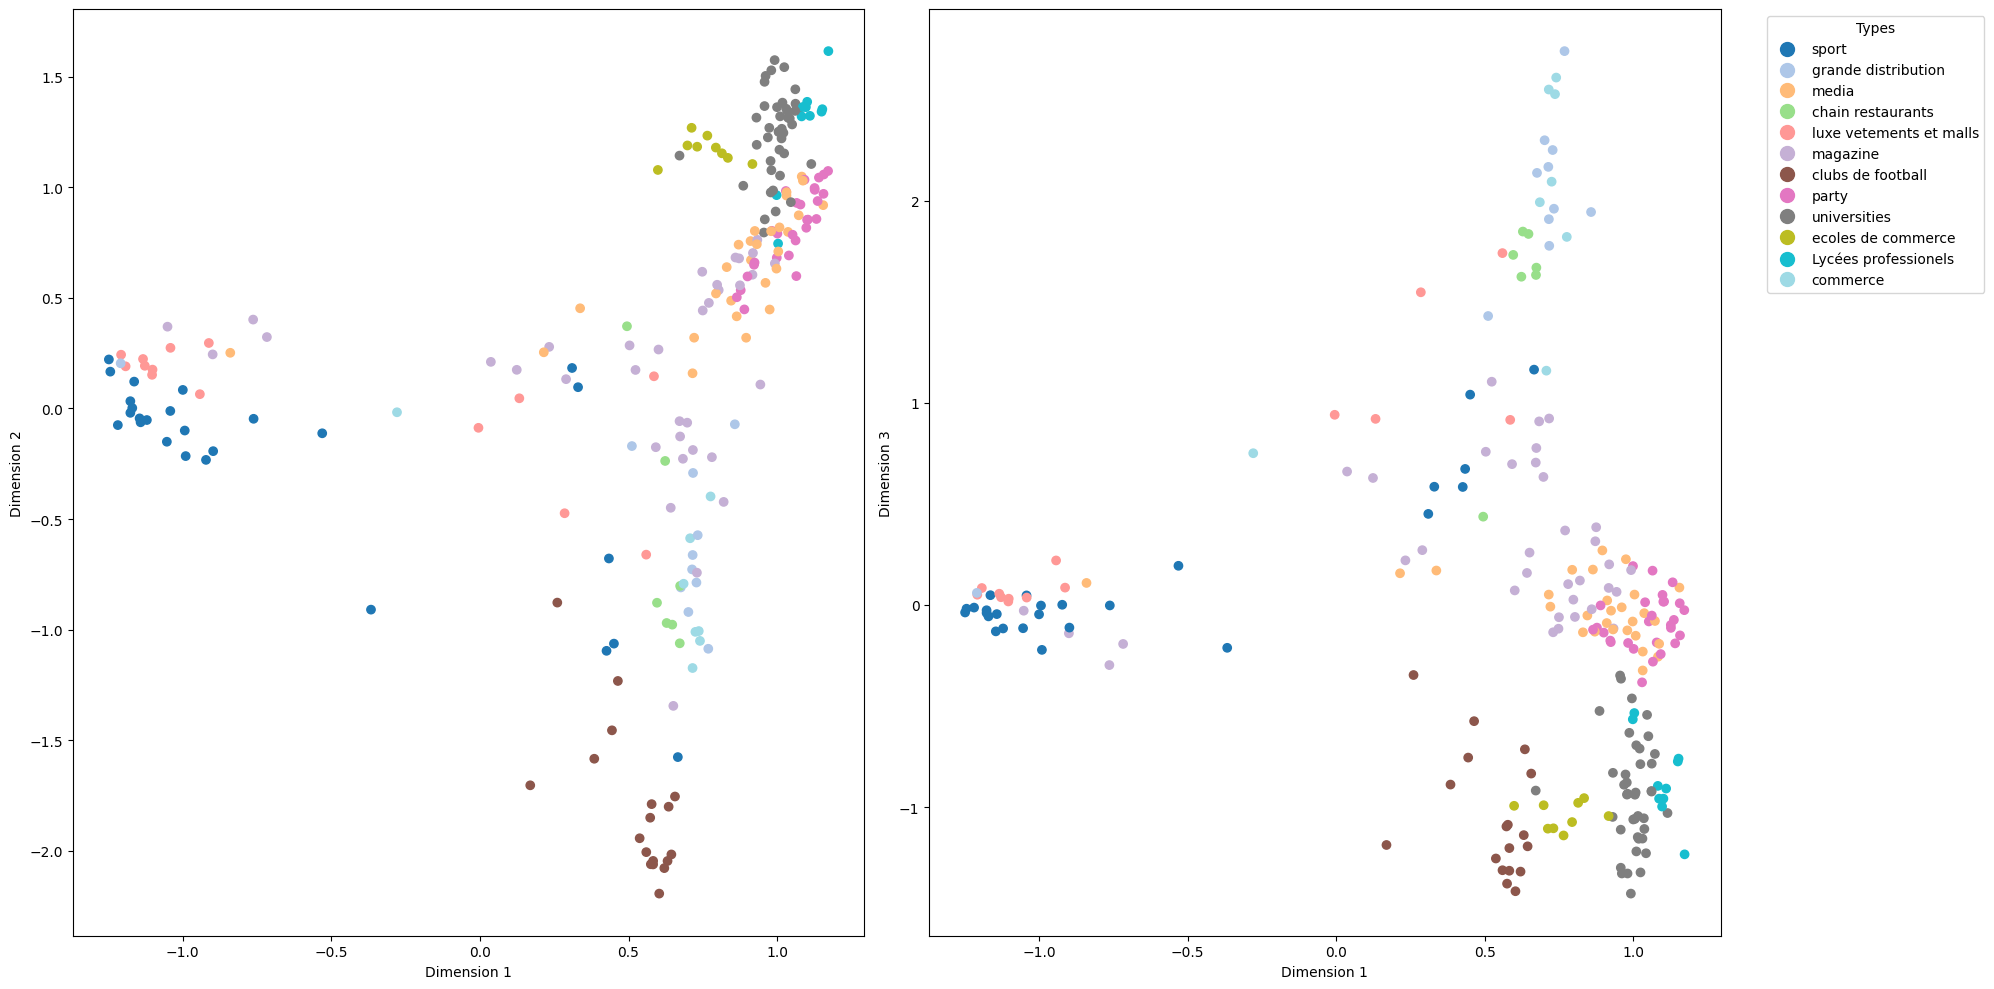

In [109]:


types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Create a mapping of types to colors
type_color_mapping = {t: cmap(i) for i, t in enumerate(types)}

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(column_coordinates[0], column_coordinates[1], c=colors[column_coordinates.index])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(column_coordinates[0], column_coordinates[2], c=colors[column_coordinates.index])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in type_color_mapping.values()]
plt.legend(legend_handles, type_color_mapping.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

In [122]:
column_coordinates

0         1         2
twitter_name                                 
24heuresactu     0.911811  0.671406  0.022413
ACAjaccio        0.574993 -2.061257 -1.377884
AJA              0.631213 -2.046493 -1.137964
ASICSFrance      0.433976 -0.678342  0.672704
AS_Monaco        0.384718 -1.584113 -0.888000
...                   ...       ...       ...
univbourgogne    1.007564  1.170300 -0.927300
universitereims  0.978295  0.977042 -0.937622
univrouen        0.994951  0.890979 -0.461935
velomagazine     0.820007 -0.422540  0.120907
vinted          -0.278897 -0.017040  0.750446

[235 rows x 3 columns]

/tmp/ipykernel_642238/2563261966.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_642238/2563261966.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(column_coordinates[0][i], column_coordinates[1][i], brand, color=colors[brand], fontsize=8)  # reduce font size here


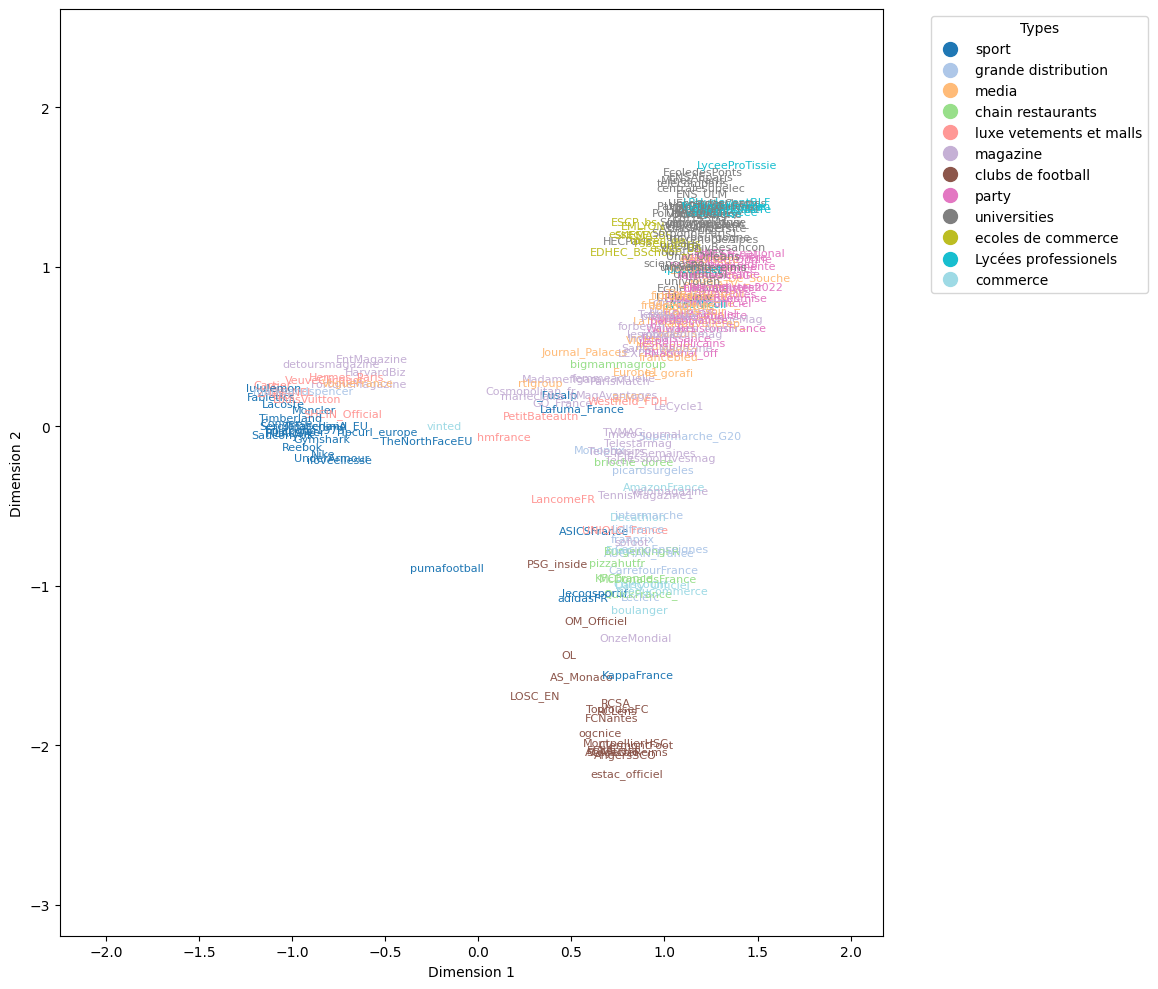

In [6]:
types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Create a mapping of types to colors
type_color_mapping = {t: cmap(i) for i, t in enumerate(types)}

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot

# Iterate over the data and place the text
for i, brand in enumerate(column_coordinates.index):
    plt.text(column_coordinates[0][i], column_coordinates[1][i], brand, color=colors[brand], fontsize=8)  # reduce font size here

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Adjust the limits of the plot
plt.xlim(column_coordinates[0].min() - 1, column_coordinates[0].max() + 1)
plt.ylim(column_coordinates[1].min() - 1, column_coordinates[1].max() + 1)

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in type_color_mapping.values()]
plt.legend(legend_handles, type_color_mapping.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

/tmp/ipykernel_642238/60160852.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_642238/60160852.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates[0][i], column_coordinates[1][i], brand, color=colors[brand], fontsize=6))


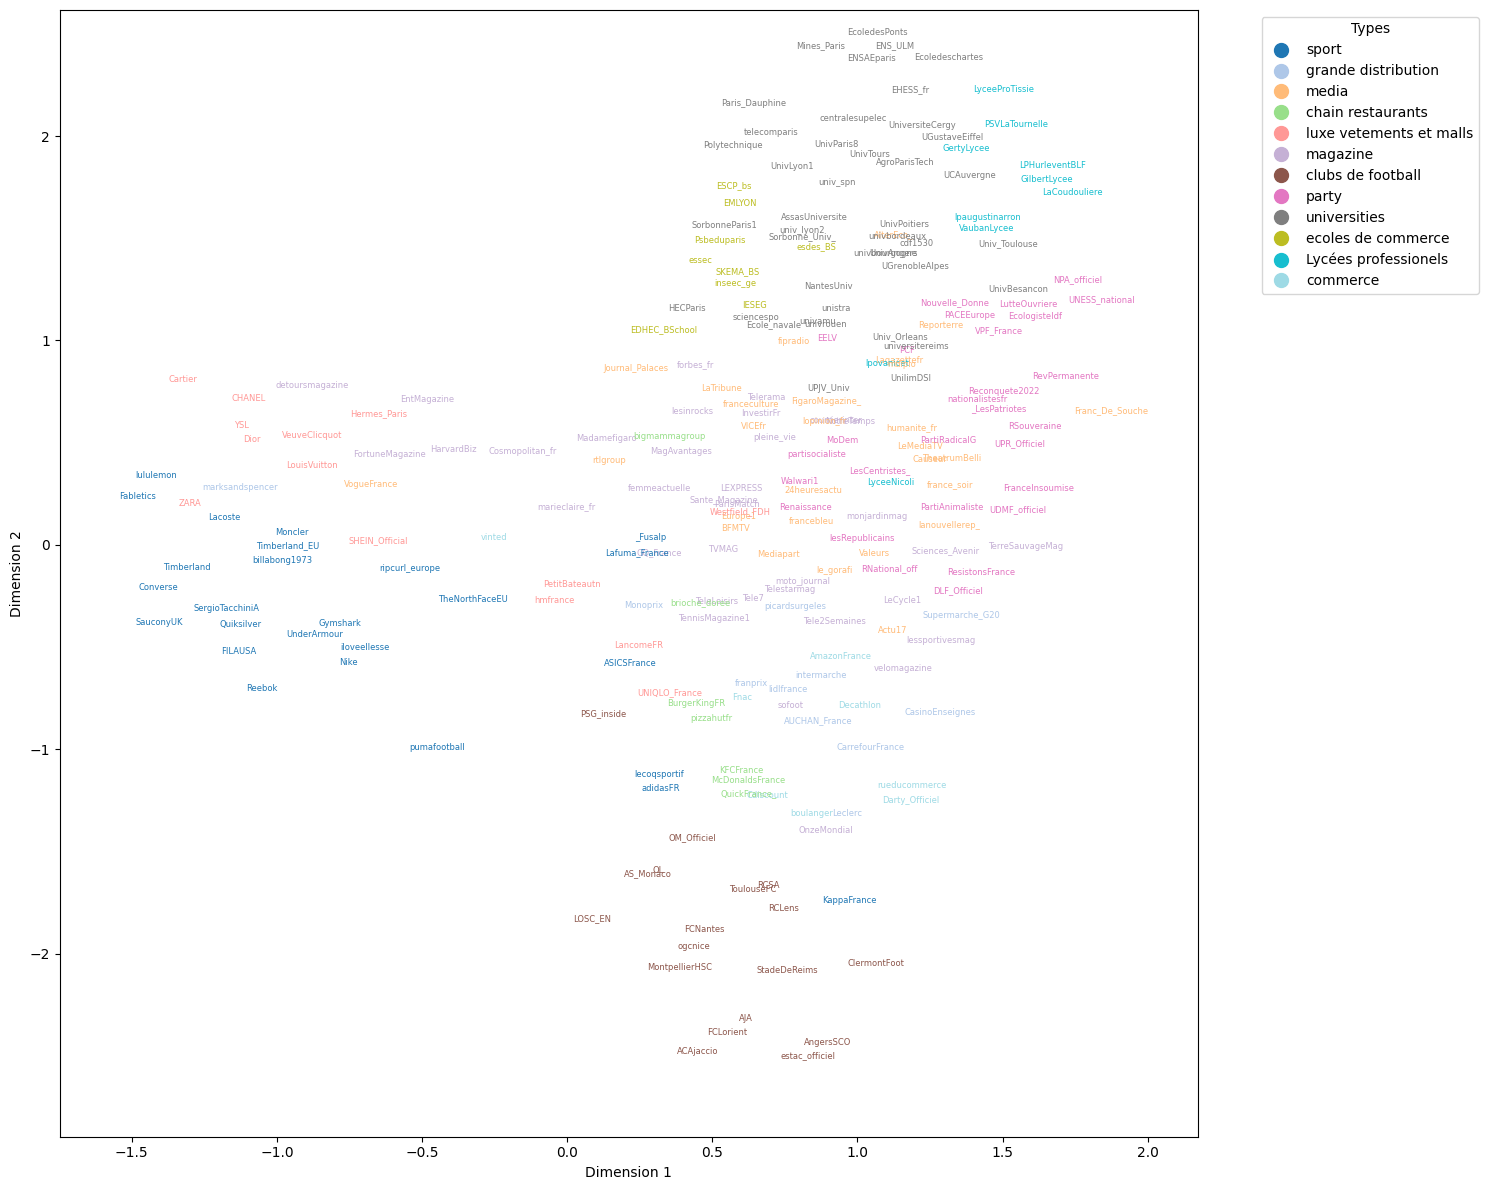

In [7]:
from adjustText import adjust_text

types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Create a mapping of types to colors
type_color_mapping = {t: cmap(i) for i, t in enumerate(types)}

plt.figure(figsize=(15, 12))

texts = []  # list to store the text objects

# Iterate over the data and place the text
for i, brand in enumerate(column_coordinates.index):
    texts.append(plt.text(column_coordinates[0][i], column_coordinates[1][i], brand, color=colors[brand], fontsize=6))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Adjust the limits of the plot
plt.xlim(column_coordinates[0].min() - 0.5, column_coordinates[0].max() + 1)
plt.ylim(column_coordinates[1].min() - 0.7, column_coordinates[1].max() + 1)

# Adjust the positions of the text to minimize overlaps
for _ in range(10):  # increase the number of iterations here
    adjust_text(texts, expand_points=(1.2, 1.2), autoalign=False)

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in type_color_mapping.values()]
plt.legend(legend_handles, type_color_mapping.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

/tmp/ipykernel_642238/2401165337.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_642238/2401165337.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates[0][i], column_coordinates[2][i], brand, color=colors[brand], fontsize=6))


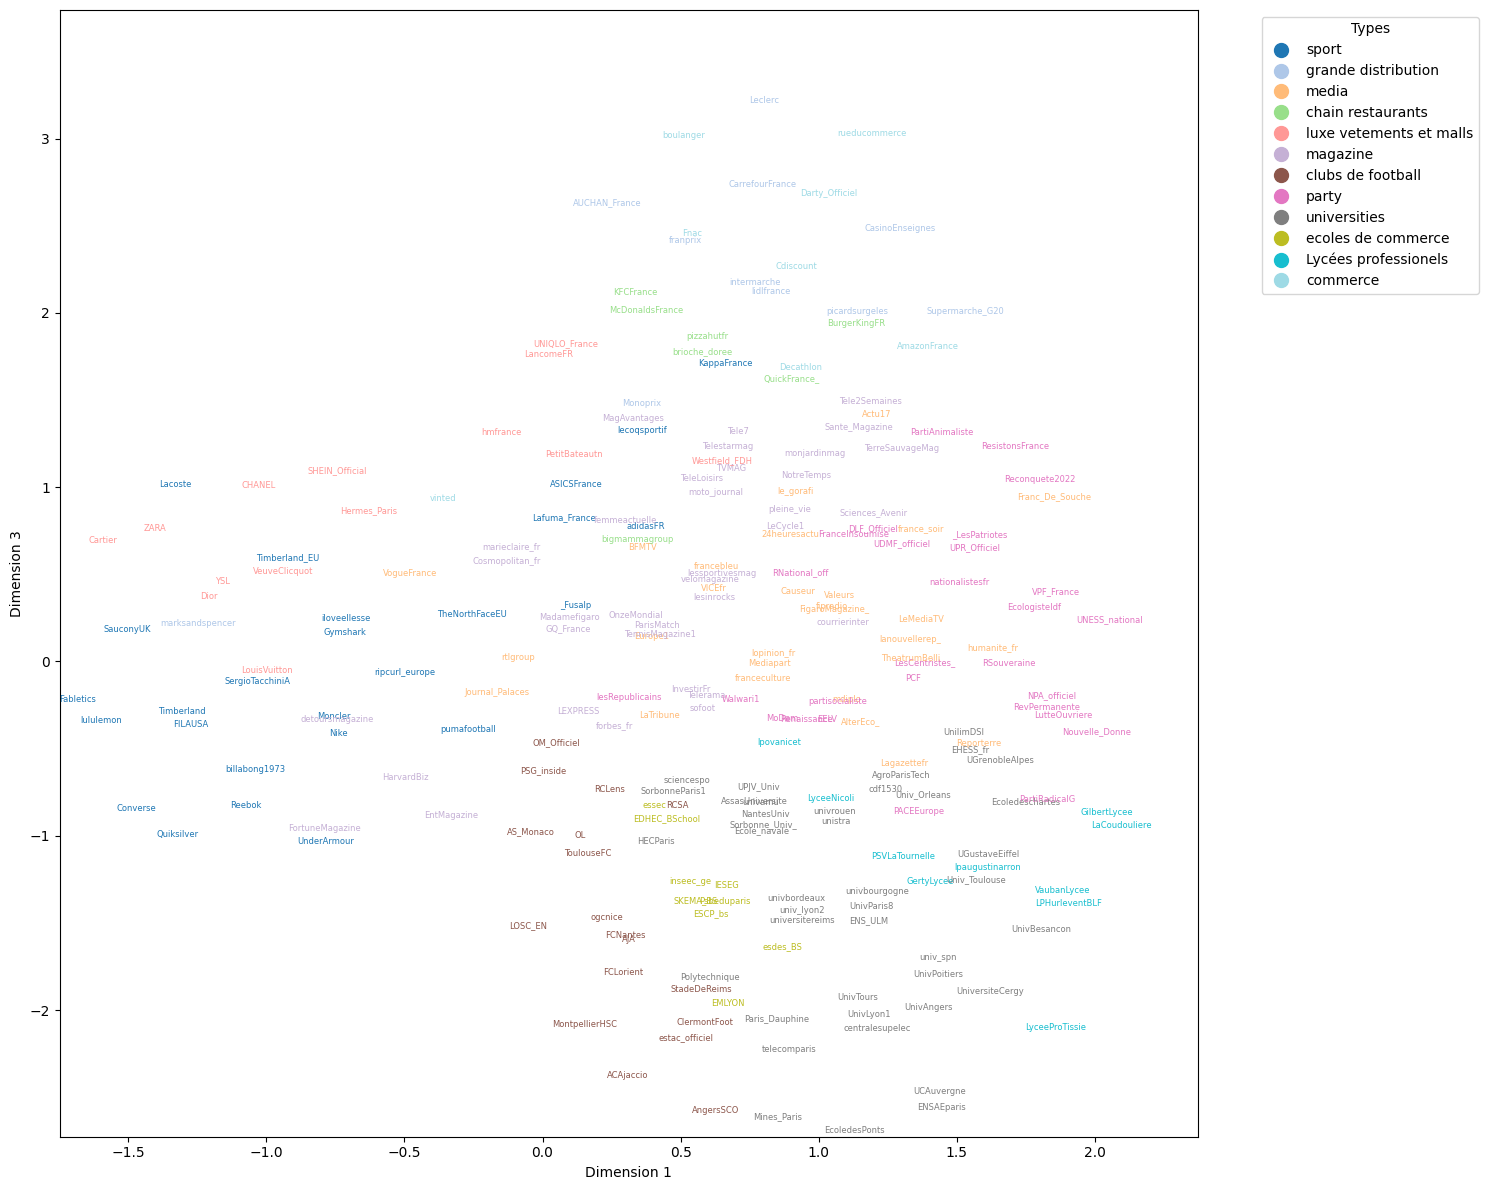

In [28]:
from adjustText import adjust_text

types = unique_marker_df['type'].unique()
cmap = cm.get_cmap('tab20', len(types))

# Get the colors for the brands
colors = unique_marker_df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

# Create a mapping of types to colors
type_color_mapping = {t: cmap(i) for i, t in enumerate(types)}

plt.figure(figsize=(15, 12))

texts = []  # list to store the text objects

# Iterate over the data and place the text
for i, brand in enumerate(column_coordinates.index):
    texts.append(plt.text(column_coordinates[0][i], column_coordinates[2][i], brand, color=colors[brand], fontsize=6))

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 3')

# Adjust the limits of the plot
plt.xlim(column_coordinates[0].min() - 0.5, column_coordinates[0].max() + 1.2)
plt.ylim(column_coordinates[2].min() - 1.3, column_coordinates[2].max() + 1)

# Adjust the positions of the text to minimize overlaps
for _ in range(20):  # increase the number of iterations here
    adjust_text(texts, expand_points=(0.5, 0.5), autoalign=False)

# Create legend
legend_handles = [mlines.Line2D([], [], color=color, marker='o', linestyle='', markersize=10) for color in type_color_mapping.values()]
plt.legend(legend_handles, type_color_mapping.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

plt.tight_layout()
plt.show()

Function to plot type of interest

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

def plot_type2(df, column_coordinates, type_to_plot, dim1, dim2):
    # Filter for the specified type
    type_df = df[df['type'] == type_to_plot]

    # Use only specified type twitter_names in column_coordinates
    column_coordinates_type = column_coordinates[column_coordinates.index.isin(type_df['twitter_name'])]

    types = df['type'].unique()
    cmap = cm.get_cmap('tab20', len(types))

    # Get the colors for the types
    colors = df.set_index('twitter_name')['type'].apply(lambda x: cmap(np.where(types == x)[0][0]))

    # Create a scatter plot
    plt.figure(figsize=(20, 10))

    scatter = plt.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=colors[column_coordinates_type.index])

    # Add labels
    texts = []
    for i, twitter_name in enumerate(column_coordinates_type.index):
        texts.append(plt.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name))

    # Adjust text to avoid overlaps
    adjust_text(texts)

    # Create a legend
    legend_elements = [Patch(facecolor=cmap(i), edgecolor=cmap(i), label=t) for i, t in enumerate(types)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Types")

    plt.xlabel(f'Dimension {dim1+1}')
    plt.ylabel(f'Dimension {dim2+1}')

    plt.show()

/tmp/ipykernel_642238/3807610003.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_642238/3807610003.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(plt.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name))


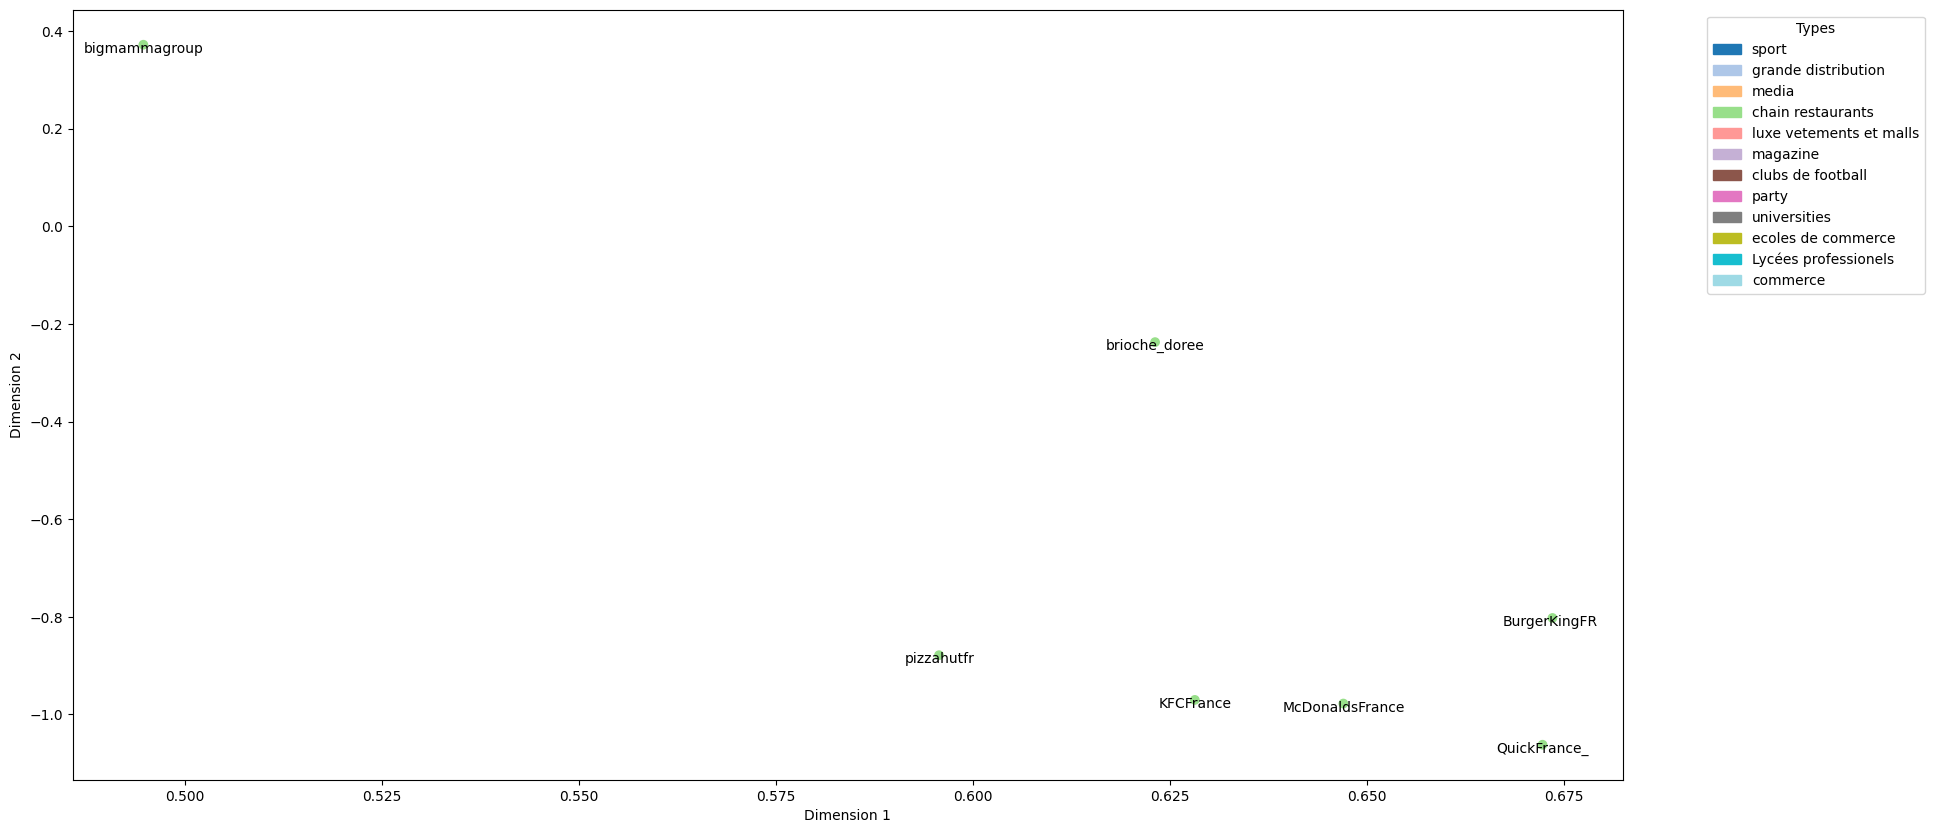

In [11]:
plot_type2(unique_marker_df, column_coordinates, 'chain restaurants', 0, 1)

Plot all types separately

In [112]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from adjustText import adjust_text

def plot_all_types_separately(df, column_coordinates, dim1, dim2):
    types = df['type'].unique()
    cmap = cm.get_cmap('tab20', len(types))

    # Create a subplot for each type
    fig, axs = plt.subplots(len(types), 1, figsize=(8, 7 * len(types)))  # Adjust the size here

    for ax, type_to_plot in zip(axs, types):
        # Filter for the specified type
        type_df = df[df['type'] == type_to_plot]

        # Use only specified type twitter_names in column_coordinates
        column_coordinates_type = column_coordinates[column_coordinates.index.isin(type_df['twitter_name'])]

        # Get the color for the type
        color = cmap(np.where(types == type_to_plot)[0][0])

        # Create a scatter plot with transparency and smaller point size
        scatter = ax.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=color, alpha=0.5, s=40)

        # Add labels with smaller font size
        texts = []
        for i, twitter_name in enumerate(column_coordinates_type.index):
            texts.append(ax.text(column_coordinates_type[dim1][i], column_coordinates_type[dim2][i], twitter_name, fontsize=8))

        # Adjust text to avoid overlaps
        adjust_text(texts, ax=ax)

        # Set the title, x-label, and y-label
        ax.set_title(f'Type: {type_to_plot}')
        ax.set_xlabel(f'Dimension {dim1+1}')
        ax.set_ylabel(f'Dimension {dim2+1}')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_356833/2377829706.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(types))
/tmp/ipykernel_356833/2377829706.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(column_coordinates_type[dim1], column_coordinates_type[dim2], c=color, alpha=0.5, s=40)
/tmp/ipykernel_356833/2377829706.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). 

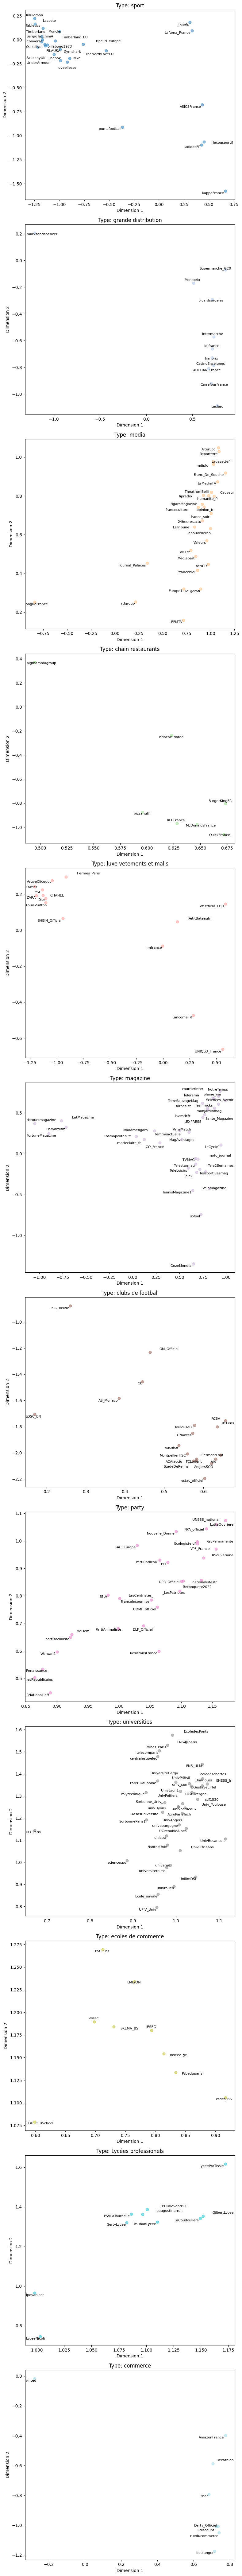

In [47]:
plot_all_types_separately(unique_marker_df, column_coordinates, 0, 1)